LSTM

In [90]:
!pip install yfinance


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [92]:

# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('MGLU3.SA', period="5y")


[*********************100%***********************]  1 of 1 completed


In [93]:
# Exibir os primeiros 5 registros
print(mglu3.head(5))

Price        Adj Close       Close        High         Low        Open  \
Ticker        MGLU3.SA    MGLU3.SA    MGLU3.SA    MGLU3.SA    MGLU3.SA   
Date                                                                     
2020-01-16  124.644333  125.005966  127.952232  122.293526  126.736313   
2020-01-17  126.719406  127.087059  127.274124  124.164169  125.800987   
2020-01-20  130.566467  130.945267  130.945267  126.385567  126.549248   
2020-01-21  130.356613  130.734818  132.675613  130.033325  130.290543   
2020-01-22  129.843689  130.220398  133.517410  128.209442  132.137802   

Price        Volume  
Ticker     MGLU3.SA  
Date                 
2020-01-16  3583274  
2020-01-17  2585629  
2020-01-20  3167204  
2020-01-21  3448775  
2020-01-22  3855607  


In [94]:
# Pegue os 7 últimos elementos do dataframe 'mglu3'
mglu3.tail(7)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,,
2025-01-08,6.17,6.17,6.48,6.07,6.46,26135100
2025-01-09,6.01,6.01,6.17,5.90,6.13,23940600
2025-01-10,6.03,6.03,6.14,5.90,6.02,18164800
2025-01-13,5.81,5.81,6.08,5.77,6.07,17078200
2025-01-14,5.91,5.91,5.92,5.71,5.86,24854100
2025-01-15,6.37,6.37,6.43,6.00,6.01,32608200
2025-01-16,5.94,5.94,6.34,5.92,6.28,29222900


In [95]:
mglu3_close = mglu3['Close'].dropna().to_numpy().reshape(-1, 1)
mglu3_close

array([[125.00596619],
       [127.08705902],
       [130.94526672],
       ...,
       [  5.90999985],
       [  6.36999989],
       [  5.94000006]])

In [96]:
mglu3_close[0].size

1

In [97]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

In [98]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [99]:
data

,Close,Scaled_Close
0,125.005966,0.475005
1,127.087059,0.483298
2,130.945267,0.498674
3,130.734818,0.497835
4,130.220398,0.495785
...,...,...
1240,6.030000,0.000877
1241,5.810000,0.000000
1242,5.910000,0.000399
1243,6.370000,0.002232


In [100]:
# Função para criar janelas de dados
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [101]:
# Criar conjunto de dados
window_size = 60 # 60 ultimos dias
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [102]:
len(X)

1185

In [103]:
print(X[1].size)

60


In [104]:
X.size

71100

In [105]:
y[0].size

1

In [106]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [107]:
# Ajustar o formato para o LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [108]:
# Criar o modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
# Compilar o modelo
# A função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [110]:
# Treinar o modelo
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - loss: 0.0932
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0054
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0037
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0038
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0038
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0031
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0034
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0036
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0034
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0030
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0036
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0027
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0029
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0036
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0027


In [117]:
# Fazer previsões
lstm_predictions = lstm_model.predict(X_test_lstm)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)
lstm_predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


array([[18.038393 ],
       [18.151411 ],
       [18.306078 ],
       [18.482065 ],
       [18.670195 ],
       [18.83277  ],
       [18.983248 ],
       [19.108488 ],
       [19.229319 ],
       [19.312117 ],
       [19.335304 ],
       [19.374096 ],
       [19.44305  ],
       [19.517778 ],
       [19.632666 ],
       [19.76235  ],
       [19.880466 ],
       [20.021528 ],
       [20.136108 ],
       [20.21912  ],
       [20.246967 ],
       [20.220629 ],
       [20.15695  ],
       [20.046251 ],
       [19.912695 ],
       [19.772821 ],
       [19.627249 ],
       [19.463291 ],
       [19.352081 ],
       [19.234    ],
       [19.149118 ],
       [19.068914 ],
       [18.965153 ],
       [18.841484 ],
       [18.65125  ],
       [18.432236 ],
       [18.192139 ],
       [17.938396 ],
       [17.669006 ],
       [17.378464 ],
       [17.118261 ],
       [16.869701 ],
       [16.671282 ],
       [16.539211 ],
       [16.444721 ],
       [16.36585  ],
       [16.271065 ],
       [16.11

In [118]:
#pegando o erro médio quadrático (RMSE)
rmse = np.sqrt(np.mean(lstm_predictions - y_test) ** 2)
rmse
len(lstm_predictions)

237

In [132]:
#criando o grafico do modelo
treinamento = mglu3.iloc[:len(X_train), :]
treinamento

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,,
2020-01-16,124.644333,125.005966,127.952232,122.293526,126.736313,3583274
2020-01-17,126.719406,127.087059,127.274124,124.164169,125.800987,2585629
2020-01-20,130.566467,130.945267,130.945267,126.385567,126.549248,3167204
2020-01-21,130.356613,130.734818,132.675613,130.033325,130.290543,3448775
2020-01-22,129.843689,130.220398,133.517410,128.209442,132.137802,3855607
...,...,...,...,...,...,...
2023-10-31,12.439800,12.439800,12.907462,12.439800,12.813929,15512795
2023-11-01,12.439800,12.439800,12.720397,12.252735,12.439800,14853718


In [134]:
df_teste = pd.DataFrame({"Close": mglu3['Close'].iloc[len(X_train):],
                        "predicoes": lstm_predictions.reshape(len(lstm_predictions))})


ValueError: Data must be 1-dimensional, got ndarray of shape (297, 1) instead

Random Forest

In [ ]:

# Criar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [17]:

# Fazer previsões
rf_predictions = rf_model.predict(X_test)

# Inverter a normalização
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))


In [18]:

# Valores reais
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


In [19]:

# Calcular o erro médio quadrático (MSE)
lstm_mse = mean_squared_error(y_test_original, lstm_predictions)
rf_mse = mean_squared_error(y_test_original, rf_predictions)

print(f"LSTM MSE: {lstm_mse}")
print(f"Random Forest MSE: {rf_mse}")


LSTM MSE: 1.427069066342056
Random Forest MSE: 19.0367642365976


Comparativo Entre os dois modelos

In [20]:

# Obter as previsões para os próximos 5 dias
last_window = scaled_data[-window_size:]
last_window = last_window.reshape(1, window_size, 1)


In [ ]:

# Previsão do LSTM
lstm_forecasts = []
for _ in range(5):
    next_prediction = lstm_model.predict(last_window)
    lstm_forecasts.append(scaler.inverse_transform(next_prediction.reshape(-1, 1))[0][0])
    
    # Atualizar a janela de entrada para a próxima previsão
    last_window = np.append(last_window[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)

    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


In [22]:

# Previsão do Random Forest
last_window_rf = scaled_data[-window_size:]
rf_forecasts = []
for _ in range(5):
    next_rf_prediction = rf_model.predict(last_window_rf.reshape(1, -1))
    rf_forecasts.append(scaler.inverse_transform(next_rf_prediction.reshape(-1, 1))[0][0])
    
    # Atualizar a janela de entrada para a próxima previsão
    last_window_rf = np.append(last_window_rf[1:], next_rf_prediction, axis=0)


In [23]:

# Arredondar as previsões
lstm_forecasts = [round(pred, 2) for pred in lstm_forecasts]
rf_forecasts = [round(pred, 2) for pred in rf_forecasts]


In [24]:

# Criar a tabela com pandas
days = [f"Dia {i + 1}" for i in range(5)]
forecast_data = {
    "Dia": days,
    "Previsão LSTM": lstm_forecasts,
    "Previsão Random Forest": rf_forecasts,
}

forecast_table = pd.DataFrame(forecast_data)


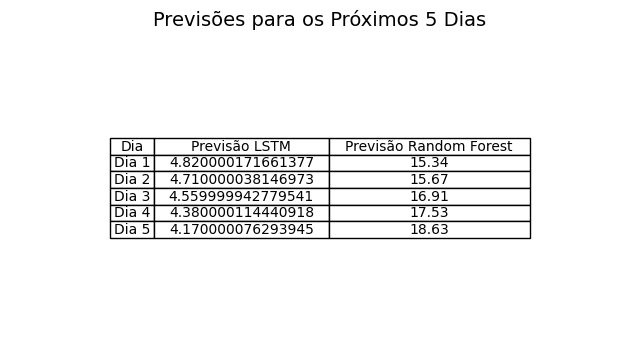

In [ ]:

# Criar o plot da tabela
plt.figure(figsize=(8, 4))
plt.axis('tight')
plt.axis('off')

# Adicionar a tabela ao plot
table_plot = plt.table(
    cellText=forecast_table.values,
    colLabels=forecast_table.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

# Estilizar a tabela
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)
table_plot.auto_set_column_width(col=list(range(len(forecast_table.columns))))

# Exibir o plot
plt.title("Previsões para os Próximos 5 Dias", fontsize=14)
plt.show()


Comparação entre Random Forest e LSTM

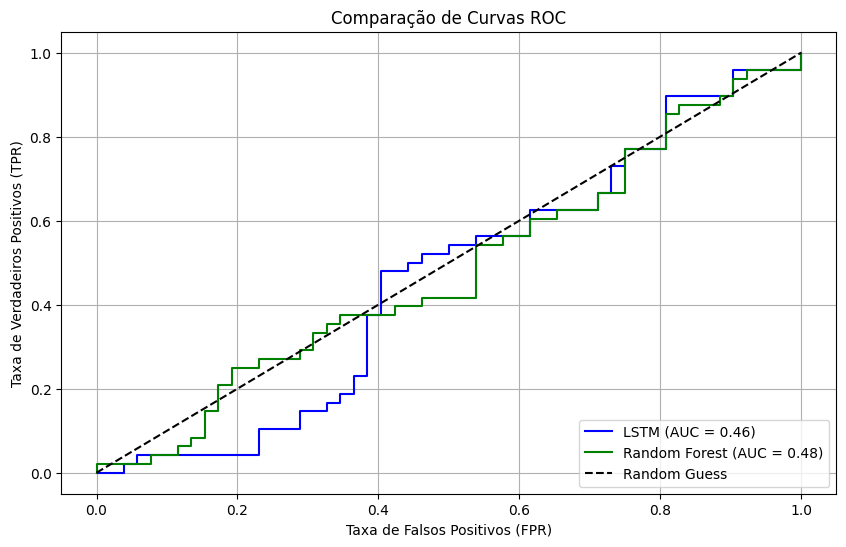

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Simulação de previsões (substitua pelos valores reais dos modelos)
y_test = np.random.choice([0, 1], size=100)  # Valores reais binários (0 ou 1)
y_pred_lstm = np.random.rand(100)            # Probabilidades previstas pelo LSTM
y_pred_rf = np.random.rand(100)              # Probabilidades previstas pelo Random Forest

# Calculando as métricas da curva ROC para ambos os modelos
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# Calculando a área sob a curva (AUC)
auc_lstm = auc(fpr_lstm, tpr_lstm)
auc_rf = auc(fpr_rf, tpr_rf)

# Plotando as curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Linha de referência (adivinhação aleatória)

plt.title('Comparação de Curvas ROC')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
